In [1]:
# pip install tensorflow[and-cuda]

In [15]:
# # https://deeplearningcourses.com/c/deep-learning-advanced-nlp
# get the data at: http://www.manythings.org/anki/
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os, sys

from tensorflow.keras.models import load_model
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

try:
  import tensorflow.keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

import tensorflow as tf
# import torch

gpus = tf.config.experimental.list_physical_devices('GPU')
if not gpus:
    print("No GPUs found")
else:
    print(f"GPUs available: {gpus}")
    
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)



# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 50

# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1


PATH_SAVEMODEL = 'SavedModel_1'

PATH_EMBEDDING = os.path.join('Data/glove.6B.%sd.txt' % EMBEDDING_DIM)
PATH_TOKENIZER_OUTPUT = os.path.join('%s/tokenizer_output.pickle' % PATH_SAVEMODEL)
PATH_TOKENIZER_INPUT = os.path.join('%s/tokenizer_input.pickle' % PATH_SAVEMODEL)

PATH_MODEL= os.path.join('%s/s2s.h5' % PATH_SAVEMODEL)
PATH_TRAIN = 'Data/train.txt'
PATH_ENCODER_MODEL = os.path.join('%s/encoder_model.h5' % PATH_SAVEMODEL)
PATH_DECODER_MODEL = os.path.join('%s/decoder_model.h5' % PATH_SAVEMODEL)

PATH_SEQUENCE_FILE = os.path.join('%s/input_sequences.pkl' % PATH_SAVEMODEL)
PATH_TARGET_SEQUENCE_FILE = os.path.join('%s/target_sequences.pkl' % PATH_SAVEMODEL)


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [14]:

import pandas as pd
# 파일에서 DataFrame 읽기 (예: CSV 파일)
df = pd.read_csv(PATH_TRAIN, delimiter='\t')

# 전체 행의 수 확인
print(f"전체 행의 개수: {df.shape[0]}")

전체 행의 개수: 20359


In [16]:
# 중복된 input_text를 추적할 집합을 제거하고 모든 질문을 처리하도록 수정
t = 0

for line in open(PATH_TRAIN, encoding='utf-8'):
    # only keep a limited number of samples
    t += 1
    if t > NUM_SAMPLES:
        break

    # input and target are separated by tab
    if '\t' not in line:
        continue

    line_split = line.rstrip().split('\t')

    # 두 번째 열 (인덱스 1)에 해당하는 input_text
    input_text = line_split[0].strip()  # 공백 제거

    # 다섯 번째 열 (인덱스 4)에 해당하는 translation
    translation = line_split[1].strip()  # 공백 제거

    # split up the input and translation
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)

print("num samples:", len(input_texts))

num samples: 20360


In [4]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# Tokenizer 저장
import pickle
with open(PATH_TOKENIZER_INPUT, 'wb') as handle:
    pickle.dump(tokenizer_inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Tokenizer 불러오기
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer_inputs = pickle.load(handle)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# Tokenizer 저장
import pickle
with open(PATH_TOKENIZER_OUTPUT, 'wb') as handle:
    pickle.dump(tokenizer_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')







# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(PATH_EMBEDDING, encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))




# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector




# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)


# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1




##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)


def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])


Found 350 unique input tokens.
Found 5450 unique output tokens.
encoder_inputs.shape: (1000, 15)
encoder_inputs[0]: [  0   0   0   0   0   0   0   0   0   0   1   4 292 293 170]
decoder_inputs[0]: [   9    7 2330 2331  482  606   18 2332 2333  482    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (1000, 109)
Loading word vectors...
Found 400000 word vectors.
Filling pre-trained embeddings...


/home/woong/study_ai/nlp_seq2seq_embededvector/.venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1726130042.923810   18676 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726130042.923972   18676 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726130042.923999   18676 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726130043.175168   18676 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I00

In [5]:

r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)



2024-09-12 10:34:05.430782: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1901308800 exceeds 10% of free system memory.
2024-09-12 10:34:06.397783: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1901308800 exceeds 10% of free system memory.


Epoch 1/10


2024-09-12 10:34:09.992065: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - acc: 0.0402 - loss: 8.5129 - val_acc: 0.0723 - val_loss: 7.6440
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - acc: 0.0612 - loss: 7.1465 - val_acc: 0.0723 - val_loss: 7.0226
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - acc: 0.0617 - loss: 6.6047 - val_acc: 0.0652 - val_loss: 7.3066
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - acc: 0.0681 - loss: 6.5427 - val_acc: 0.0727 - val_loss: 7.3680
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - acc: 0.0599 - loss: 6.4471 - val_acc: 0.0720 - val_loss: 7.3715
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - acc: 0.0687 - loss: 6.4339 - val_acc: 0.0770 - val_loss: 7.3890
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - acc: 0.0760 - loss: 6.3950 - val_acc: 0.0791 - val_loss: 7.3827
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - acc: 0.0915 - loss: 6.3463 - val_acc: 0.1052 - val_loss: 7.3125
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - acc: 0.1097 - loss: 6

In [6]:

# 가중치 비교
original_weights = model.get_weights()

# 모델을 저장
model.save(PATH_MODEL)

# 모델을 불러옴
model_loaded = load_model(PATH_MODEL, custom_objects={'custom_loss': custom_loss, 'acc': acc})

# 불러온 모델의 가중치
loaded_weights = model_loaded.get_weights()


In [7]:
# 가중치 비교
for original, loaded in zip(original_weights, loaded_weights):
    if np.array_equal(original, loaded):
        print("가중치 일치")
    else:
        print("가중치 불일치")

가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치


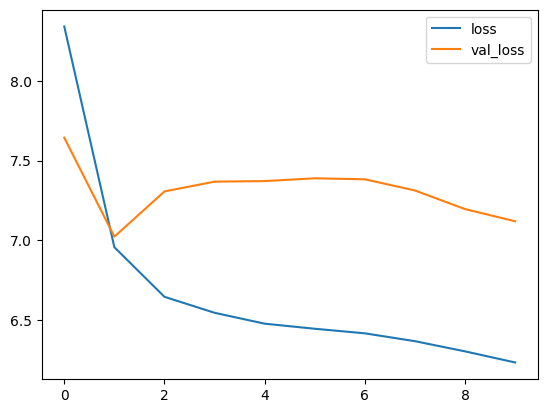

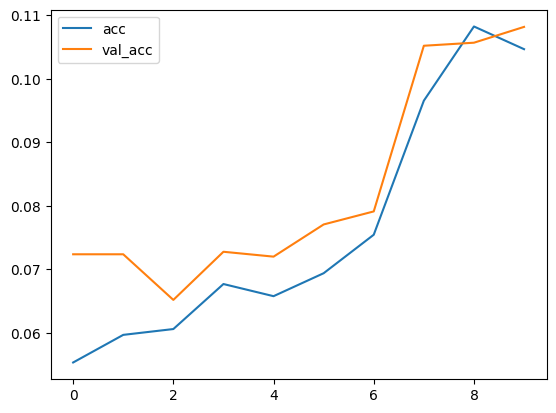

In [8]:

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()


In [9]:


##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)


In [10]:

encoder_model.save(PATH_ENCODER_MODEL)
decoder_model.save(PATH_DECODER_MODEL)

In [11]:

  # Do some test translations
i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
translation = decode_sequence(input_seq)
print('-')
print('Input:', input_texts[i])
print('Translation:', translation)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-
Input: how old was britney spears when she recorded hit me baby one more time
Translation: the the the the the the the the , the , , the , the .
